In [1]:
from segment2d import *
import numpy as np
import csv
from matplotlib import pyplot as plt
from ipywidgets import interact
# visualize the image and mask in z ax is using interact, image and mask are in one slice
import SimpleITK as sitk
import scipy.ndimage as ndimage
from metrics_segmentation import hd
from natsort import natsorted
import configparser
from pathlib import Path
import pandas as pd
import os

# predict emidec


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open("csv_files/EMIDEC_test_train_full.csv", mode="r") as f:
    reader = csv.DictReader(f)
    list_test_subject = [row["path"] for row in reader]

model_emidec = torch.load("tiramisu_emidec.pt", weights_only=False)
model_emidec.eval()
model_emidec = model_emidec.to(device)

In [3]:
import torch
from fvcore.nn import FlopCountAnalysis


# Move the model to GPU
model = FCDenseNet(in_channels=1, n_classes=5).to("cpu")

# Create a sample input tensor and move it to GPU
input_tensor = torch.randn(1, 1, 256, 256).to("cpu")  # Adjust shape for your model's input size

flops = FlopCountAnalysis(model, input_tensor)
gflops = flops.total() / 1e9  # Convert FLOPs to GFLOPs

print("GFLOPs on GPU:", gflops)

Unsupported operator aten::add_ encountered 49 time(s)
Unsupported operator aten::silu_ encountered 49 time(s)
Unsupported operator aten::feature_dropout encountered 49 time(s)
Unsupported operator aten::max_pool2d encountered 5 time(s)
Unsupported operator aten::sub encountered 10 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


GFLOPs on GPU: 12.016845312


In [10]:
from torch.profiler import profile, ProfilerActivity
# 2. Run the profiler with `with_flops=True`
inputs = torch.randn(8, 1, 256, 256).to(device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], with_flops=True) as prof:
    model_emidec(inputs)

# 3. Print the results, sorted by FLOPs
print(prof.key_averages().table(sort_by="flops"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total GFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.00%     224.040us         1.09%      58.807ms       1.131ms       0.000us         0.00%      28.472ms     547.537us            52       177.445  
                                              aten::mul         0.63%      33.869ms         0.94%      50.646ms     251.970us       0.000us         0.0

In [ ]:

metrics_emidec_header = ["patient_name", 
    "Dice_Myocardium","HD_Myocardium", "Volume_Myocardium", "Err_Myocardium(ml)",
    "Dice_Infarction", "Volume_Infarction", "Err_Infarction(ml)", "Vol_Difference_Infarction_rate(%)",
    "Dice_No-Reflow", "Volume_No-Reflow", "Err_No-Reflow(ml)", "Vol_Difference_No-Reflow_rate(%)",
    ]
# create folder to save the predicted image
os.makedirs("predicted_emidec", exist_ok=True)

with open("csv_files/EMIDEC_test_train_full.csv", mode="r") as f:
    reader = csv.DictReader(f)
    list_test_subject = [row["path"] for row in reader]
# open csv file to save the result
f = open("csv_files/result_emidec.csv", mode="w")
writer = csv.DictWriter(f, fieldnames=metrics_emidec_header)
writer.writeheader()



for image_path in list_test_subject:

    patient_name = image_path.split("/")[-3]
    # print("patient name: ", patient_name)
    mask_path = image_path.replace("Images", "Contours")
    image, affine, header = load_nii(image_path)
    mask, _, _ = load_nii(mask_path)

    data = preprocess_data_nii(image_path)
    seg = predict_data_model_emidec(data, model_emidec, min_size_remove=500).astype(np.uint8)
    save_nii(f"predicted_emidec/{patient_name}_tiramisu_seg.nii.gz", seg, affine, header)

    result = metrics_EMIDEC(mask, seg, voxel_size=header.get_zooms())
    # round the result to 3 decimal places
    result = [patient_name] + [round(r, 4) for r in result]
    # write the result to the csv file
    writer.writerow(dict(zip(metrics_emidec_header, result)))
    # break

f.close()

In [57]:
# crop the image and mask to the center of the image
image_show = image[image.shape[0]//2-64:image.shape[0]//2+64, image.shape[1]//2-64:image.shape[1]//2+64, :]
mask_show = mask[mask.shape[0]//2-64:mask.shape[0]//2+64, mask.shape[1]//2-64:mask.shape[1]//2+64, :]
seg_show = seg[seg.shape[0]//2-64:seg.shape[0]//2+64, seg.shape[1]//2-64:seg.shape[1]//2+64, :]

def plot_image_mask_z(image, mask, padded_image, padded_mask, z):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image gt")
    # ax[0].imshow(mask[..., z], cmap="jet", alpha=0.3)
    ax[1].imshow(padded_image[..., z], cmap="gray")
    ax[1].set_title("Image predict")
    ax[1].imshow(padded_mask[..., z], cmap="jet", alpha=0.5, vmin=0, vmax=4)

    ax[2].imshow(padded_image[..., z], cmap="gray", alpha=0.7)
    ax[2].imshow(mask[..., z], cmap="jet", alpha=0.5, vmin=0, vmax=4)
    ax[2].set_title("Mask gt")
    # off the axis
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    # add legend
    ax[1].legend(["Myocardium", "Infarction", "No-Reflow"], loc="upper right")


interact(lambda z: plot_image_mask_z(image_show, mask_show, image_show, seg_show, z), z=(0, image.shape[-1] - 1))

interactive(children=(IntSlider(value=3, description='z', max=6), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(z)>

# predict acdc

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# num_classes= 4
# model = FCDenseNet(in_channels=1, n_classes=num_classes)
# class_weight = [0.27, 10.00, 8.91, 8.94]  #
# segmenter = Segmenter_ACDC(
#     model,
#     class_weight,
#     num_classes,
#     0.001,
#     0.5,
#     50,
# )
# segmenter.eval()

# checkpoint = "weights_ACDC/dice_0.9137.ckpt"
# segmenter = Segmenter_ACDC.load_from_checkpoint(
#     checkpoint_path=checkpoint,
#     model=model,
#     class_weight=class_weight,
#     num_classes=num_classes,
#     learning_rate=0.001,
#     factor_lr=0.5,
#     patience_lr=50,
# )
# segmenter = segmenter.to(device)
model_acdc = torch.load("tiramisu_acdc.pt", weights_only=False)
model_acdc.eval()
model_acdc = model_acdc.to(device)

In [5]:
metrics_acdc_header = ["patient_name", 
            "Dice ED Left Ventricle", "HD ED Left Ventricle", "Volume ED Left Ventricle", "Err ED Left Ventricle(ml)",
          "Dice ED Right Ventricle", "HD ED Right Ventricle", "Volume ED Right Ventricle", "Err ED Right Ventricle(ml)",
          "Dice ED Myocardium", "HD ED Myocardium", "Volume ED Myocardium", "Err ED Myocardium(ml)",
          "Dice ES Left Ventricle", "HD ES Left Ventricle", "Volume ES Left Ventricle", "Err ES Left Ventricle(ml)",
          "Dice ES Right Ventricle", "HD ES Right Ventricle", "Volume ES Right Ventricle", "Err ES Right Ventricle(ml)",
          "Dice ES Myocardium", "HD ES Myocardium", "Volume ES Myocardium", "Err ES Myocardium(ml)"]

config = configparser.ConfigParser()
with open("csv_files/ACDC_test.csv", mode="r") as f:
    reader = csv.DictReader(f)
    list_test_subject = [row["path"] for row in reader]

test_patitent_paths = natsorted(glob.glob("ACDC/database/testing/patient*"))


# open csv file to save the result
f = open("csv_files/result_acdc.csv", mode="w")
writer = csv.DictWriter(f, fieldnames=metrics_acdc_header)
writer.writeheader()
# create folder to save the predicted mask
os.makedirs("predicted_acdc", exist_ok=True)
for patient_path in test_patitent_paths:

    info_path = patient_path + "/Info.cfg"
    with open(info_path, mode="r") as f:
        config.read_string(f"[info]\n{f.read()}")
    ED_index = f"0{config['info']['ED']}" if int(config['info']['ED']) < 10 else f"{config['info']['ED']}"
    ES_index = f"0{config['info']['ES']}" if int(config['info']['ES']) < 10 else f"{config['info']['ES']}"
    patient_name = patient_path.split("/")[-1]
    ED_image_path = patient_path + f"/{patient_name}_frame{ED_index}.nii.gz"
    ES_image_path = patient_path + f"/{patient_name}_frame{ES_index}.nii.gz"
    ED_mask_path = patient_path + f"/{patient_name}_frame{ED_index}_gt.nii.gz"
    ES_mask_path = patient_path + f"/{patient_name}_frame{ES_index}_gt.nii.gz"


    ED_image, ED_affine, ED_header = load_nii(ED_image_path)
    ES_image, ES_affine, ES_header = load_nii(ES_image_path)
    ED_mask, _, _ = load_nii(ED_mask_path)
    ES_mask, _, _ = load_nii(ES_mask_path)

    ED_data = preprocess_data_nii(ED_image_path)
    ES_data = preprocess_data_nii(ES_image_path)
    ED_seg = predict_data_model(ED_data, model_acdc, min_size_remove=800).astype(np.uint8)
    ES_seg = predict_data_model(ES_data, model_acdc, min_size_remove=800).astype(np.uint8)

    result_ED = metrics_ACDC(ED_mask, ED_seg, voxel_size=ED_header.get_zooms())
    result_ES = metrics_ACDC(ES_mask, ES_seg, voxel_size=ES_header.get_zooms())
    # round the result to 3 decimal places
    result = [patient_name] + [round(r, 4) for r in result_ED] + [round(r, 4) for r in result_ES]

    # write the result to the csv file
    writer.writerow(dict(zip(metrics_acdc_header, result)))
    # save the predicted mask
    save_nii(f"predicted_acdc/{patient_name}_tiramisu_seg_ED.nii.gz", ED_seg, ED_affine, ED_header)
    save_nii(f"predicted_acdc/{patient_name}_tiramisu_seg_ES.nii.gz", ES_seg, ES_affine, ES_header)
    # break

f.close()

In [23]:
# read the result_acdc.csv file
result_acdc = pd.read_csv("csv_files/result_acdc.csv")
# remove the Volume column
result_acdc = result_acdc.drop(columns=["Volume ED Left Ventricle", "Volume ED Right Ventricle", "Volume ED Myocardium", "Volume ES Left Ventricle", "Volume ES Right Ventricle", "Volume ES Myocardium"])
result_acdc.head()
# Melt everything except patient_name
df_long = result_acdc.melt(id_vars='patient_name', var_name='Metric_Label', value_name='Value')

# Extract Metric type (Dice, HD, Err), Phase (ED, ES), and Region (LV, RV, MYO)
df_long[['Metric', 'Phase', 'Region']] = df_long['Metric_Label'].str.extract(r'(\w+)\s+(ED|ES)\s+(Left Ventricle|Right Ventricle|Myocardium)')

result_emidec = pd.read_csv("csv_files/result_emidec.csv")
result_emidec = result_emidec.drop(columns=["Volume_Myocardium","Volume_Infarction", "Volume_No-Reflow","HD_Myocardium"])
result_emidec.head()
df_emidec = result_emidec.melt(id_vars='patient_name', 
                               var_name='Metric_Label', 
                               value_name='Value')

# Extract Metric + Region
df_emidec[['Metric', 'Region']] = df_emidec['Metric_Label'].str.extract(
    r'(Dice|Err|Vol_Difference).*_(Myocardium|Infarction|No-Reflow)'
)

# Rename 'Err' to 'Volume Error' for clarity
df_emidec['Metric'] = df_emidec['Metric'].replace({'Err': 'Volume Error'})



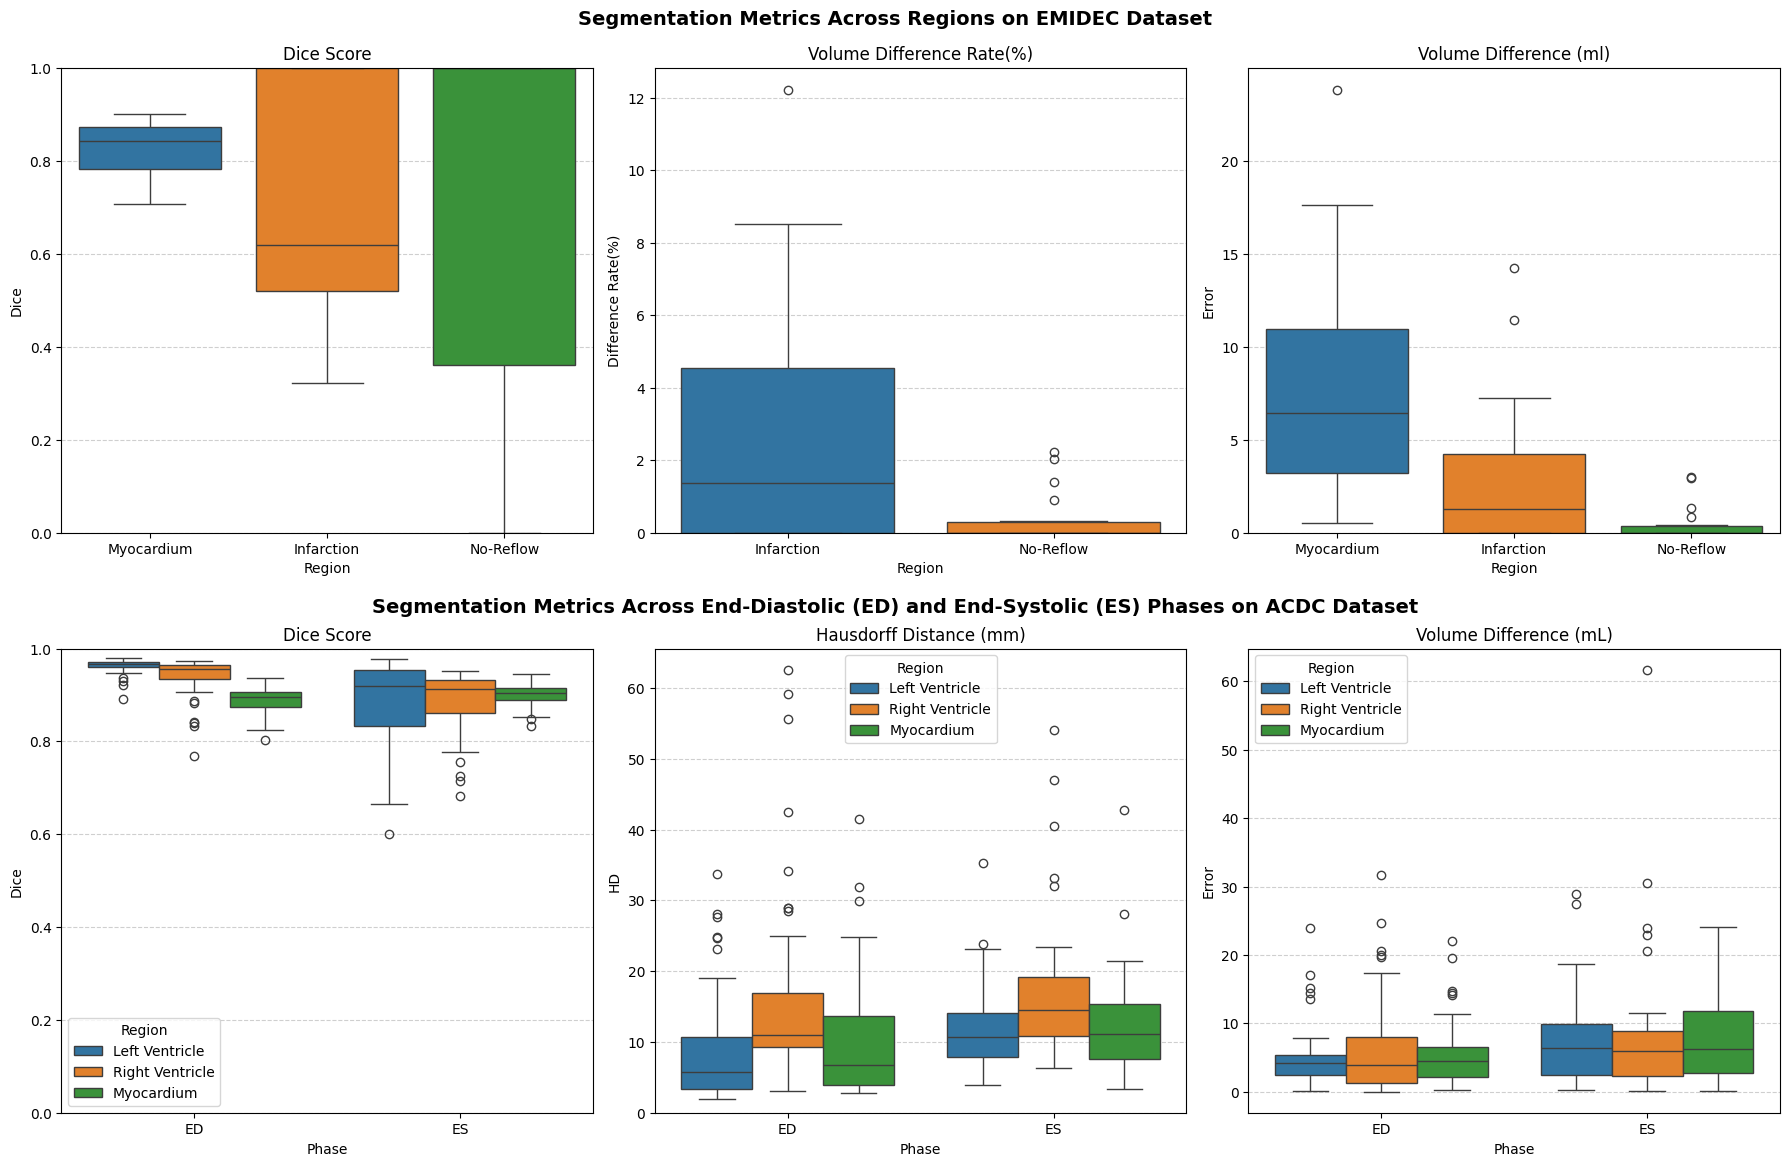

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create a single figure with 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ==========================================================
# === Row 1: EMIDEC dataset
# ==========================================================
metrics_emidec = ['Dice', 'Vol_Difference', 'Volume Error']
titles_emidec = ['Dice Score', 'Volume Difference Rate(%)', 'Volume Difference (ml)']

for ax, metric, title in zip(axes[0], metrics_emidec, titles_emidec):
    subset = df_emidec[df_emidec['Metric'] == metric]
    
    sns.boxplot(
        x='Region',
        y='Value',
        hue='Region',
        data=subset,
        ax=ax,
        showfliers=True,  # optional: hides outliers for cleaner look
        legend=False
    )
    
    ax.set_title(title)
    ax.set_xlabel('Region')
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    if metric == 'Dice':
        ax.set_ylim(0, 1)
    elif metric == 'Vol_Difference':
        ax.set_ylim(0, None)
        ax.set_ylabel('Difference Rate(%)')
    elif metric == 'Volume Error':
        ax.set_ylim(0, None)
        ax.set_ylabel('Error')

# Add EMIDEC subtitle manually
fig.text(0.5, 0.96, 'Segmentation Metrics Across Regions on EMIDEC Dataset',
         ha='center', va='center', fontsize=14, fontweight='bold')

# ==========================================================
# === Row 2: ACDC dataset
# ==========================================================
metrics_acdc = ['Dice', 'HD', 'Err']
titles_acdc = ['Dice Score', 'Hausdorff Distance (mm)', 'Volume Difference (mL)']

for ax, metric, title in zip(axes[1], metrics_acdc, titles_acdc):
    subset = df_long[df_long['Metric'] == metric]
    
    sns.boxplot(
        x='Phase',
        y='Value',
        hue='Region',
        data=subset,
        ax=ax,
        showfliers=True,
        legend=True
    )
    
    ax.set_title(title)
    ax.set_xlabel('Phase')
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    if metric == 'Dice':
        ax.set_ylim(0, 1)
    elif metric == 'HD':
        ax.set_ylim(0, None)
    elif metric == 'Err':
        ax.set_ylabel('Error')

plt.subplots_adjust(hspace=0.9, bottom=0.12)

# Add ACDC subtitle manually
fig.text(0.5, 0.47, 'Segmentation Metrics Across End-Diastolic (ED) and End-Systolic (ES) Phases on ACDC Dataset',
         ha='center', va='center', fontsize=14, fontweight='bold')

# ==========================================================
# === Final formatting
# ==========================================================

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.25)
plt.savefig("figures/segmentation_metrics.png", dpi=300)

plt.show()


In [27]:
ED_image.shape

(216, 256, 8)

In [46]:
# make the crop center of the image 128
image = ED_image[ED_image.shape[0]//2-64:ED_image.shape[0]//2+64, ED_image.shape[1]//2-64:ED_image.shape[1]//2+64, :]
mask = ED_mask[ED_mask.shape[0]//2-64:ED_mask.shape[0]//2+64, ED_mask.shape[1]//2-64:ED_mask.shape[1]//2+64, :]
seg = ED_seg[ED_seg.shape[0]//2-64:ED_seg.shape[0]//2+64, ED_seg.shape[1]//2-64:ED_seg.shape[1]//2+64, :]

def plot_image_mask_z(image, mask, padded_image, padded_mask, z):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image gt")
    # ax[0].imshow(mask[..., z], cmap="jet", alpha=0.3)
    ax[1].imshow(padded_image[..., z], cmap="gray", alpha=0.7)
    ax[1].set_title("Image predict")
    ax[1].imshow(padded_mask[..., z], cmap="jet", alpha=0.5, vmin=0, vmax=4)

    ax[2].imshow(padded_image[..., z], cmap="gray", alpha=0.7)
    ax[2].imshow(mask[..., z], cmap="jet", alpha=0.5)
    ax[2].set_title("Mask gt")
    # off the axis
    ax[0].axis('off')
    ax[1].axis('off')


interact(lambda z: plot_image_mask_z(image, mask, image, seg, z), z=(0, ED_image.shape[-1] - 1))

interactive(children=(IntSlider(value=3, description='z', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(z)>

# predict Table 2 dataset

In [ ]:
model_name = "tiramisu_emidec.pt" # "tiramisu_emidec.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_acdc = torch.load(model_name, weights_only=False)
model_acdc.eval()
model_acdc = model_acdc.to(device)

def preprocess_data_table2(image_nrrd_path):
    data = {}
    patient_image = nrrd.read(image_nrrd_path)
    image = patient_image[0]
    image = min_max_normalize(image)

    resized_image, restore_info = crop_resize_image(image, 256)
    # padded_mask = pad_background_with_index(mask, crop_index, padded_index, dim2pad=cfg.DATA.DIM2PAD)
    data["restore_info"] = restore_info
    batch_images = []
    for i in range(resized_image.shape[-1]):
        slice_inputs = resized_image[..., i : i + 1]  # shape (224, 224, 1)
        slices_image = torch.from_numpy(slice_inputs.transpose(-1, 0, 1))  # shape (1, 224, 224)
        batch_images.append(slices_image)

    batch_images = torch.stack(batch_images).float()  # shape (9,1, 224, 224)
    data["image"] = batch_images
    return data
    
table2_path = "Tables 2/Tables/*/"
list_test_image = natsorted([x for x in glob.glob("Tables 2/Tables/*/*.nrrd") if "seg" not in x])
list_test_mask = natsorted([x for x in glob.glob("Tables 2/Tables/*/*seg.nrrd")])

print(len(list_test_image), len(list_test_mask))


64 64


In [ ]:
# create folder to save the predicted masks
import nrrd
csv_file = f"csv_files/result_table2_{model_name}.csv"
f = open(csv_file, mode="w")
writer = csv.DictWriter(f, fieldnames=["patient_name", "Dice"])
writer.writeheader()
os.makedirs("predicted_table2_data_emidec_model", exist_ok=True)
os.makedirs("predicted_table2_data_acdc_model", exist_ok=True)

for index in range(len(list_test_image)):
    if "42_PC" in list_test_image[index]:

        image = nrrd.read(list_test_image[index])[0]
        image_info = nrrd.read(list_test_image[index])[1]
        data = preprocess_data_table2(list_test_image[index])

        # seg = predict_data(data, segmenter, patient=patient, mvo=is_MVO, task=task).astype(np.uint8)
        num_classes = 4 if model_name == "tiramisu_acdc.pt" else 5
        seg = predict_data_model(data, model_acdc, num_classes=num_classes).astype(np.uint8)
        # give label 1, 3, 4 to 0
        seg[seg == 1] = 0
        seg[seg == 3] = 0
        seg[seg == 4] = 0
        # give label 2 to 1
        seg[seg == 2] = 1
        # write the predicted mask to the a nrrd file with image_info
        # and make name of the file is like this 1 - PGF/34 de_high res PSIR EC_PSIR_tiramisu.nrrd
        name_predict = list_test_image[index].split("/")[-2:]
        name_predict = "/".join(name_predict).replace(".nrrd", "_tiramisu_seg.nrrd")
        # make folder dir 1-PGF to save the predicted mask
        if model_name == "tiramisu_acdc.pt":
            os.makedirs(f"predicted_table2_data_acdc_model/{name_predict.split('/')[0]}", exist_ok=True)
            nrrd.write(f"predicted_table2_data_acdc_model/{name_predict}", seg, image_info)
        else:
            os.makedirs(f"predicted_table2_data_emidec_model/{name_predict.split('/')[0]}", exist_ok=True)
            nrrd.write(f"predicted_table2_data_emidec_model/{name_predict}", seg, image_info)
            
        print("write predicted mask to ", name_predict)

        mask = nrrd.read(list_test_mask[index])[0]
        dice = dice_volume_ACDC(mask, seg, class_index=1)
        writer.writerow({"patient_name": list_test_image[index].split("/")[-2], "Dice": dice})

    
    # break
f.close()

write predicted mask to  42_PCF/32 de_high res PSIR EC_PSIR_tiramisu_seg.nrrd


In [ ]:
def plot_image_mask_z(image, mask, padded_image, padded_mask, z):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image gt")
    ax[0].imshow(mask[..., z], cmap="jet", alpha=0.3)
    ax[1].imshow(padded_image[..., z], cmap="gray")
    ax[1].set_title("Image predict")
    ax[1].imshow(padded_mask[..., z], cmap="jet", alpha=0.3)
    # off the axis
    ax[0].axis('off')
    ax[1].axis('off')


interact(lambda z: plot_image_mask_z(image, mask, image, seg, z), z=(0, image.shape[-1] - 1))

interactive(children=(IntSlider(value=7, description='z', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(z)>